In [6]:
import numpy as np
from numpy.linalg import solve
import matplotlib.pyplot as plt
from matplotlib import animation
from math import sqrt
from scipy import special

In [7]:
# Initial guess of orbit state vector values
# X0,Y0 coordinates of satellite (X horizontal, Y vertical, assuming flat earth lol)
# Xdot0,Ydot0 instantaneous velocities 
# g is acceleration along Y axis 
# Xs, Ys are global varaibles describing radar station coordinates (not to be solved for)
[X0, Y0, Xdot0, Ydot0, g, Xs, Ys] = [1.5, 10.0, 2.2, 0.5, 0.3, 1.0, 1.0]

# Observation times, ranges 
# Stored as column vectors
obs_times = np.array([0,1,2,3,4]).T
obs_rhos = np.array( [7.0, 8.00390597, 8.94427191, 9.801147892, 10.630145813] ).T

# Given answer, to check convergence. Also store as column vector
# [X0, Y0, Xdot0, Ydot0, g] 
state_true = np.array( [1.0, 8.0, 2.0, 1.0, 0.5] ).T

In [8]:

def rho_fct(t, state): 
  # Expression for range (distance from observation point) given position, velocity, time
  # Xs and Ys are fixed, global variables for this problem 
  [X0, Y0, Xdot0, Ydot0, g] = [ state[0], state[1], state[2], state[3], state[4]]
  X_part = (X0 - Xs + Xdot0*t)
  Y_part = (Y0 - Ys + Ydot0*t - 0.5*g*t**2) 
  return sqrt( X_part**2 + Y_part**2 )

# dJ/dX_0^n (=-dG/dX_0^n) is a 5x5 matrix of derivatives
# Rows correspond to each observation (rho1,rho2,...)
# Columns correspond to the variable (X0,Y0,...)
def drho_dX0(t, state):
  [X0, Y0, Xdot0, Ydot0, g] = [ state[0], state[1], state[2], state[3], state[4]]
  X_part = (X0 - Xs + Xdot0*t)
  Y_part = (Y0 - Ys + Ydot0*t - 0.5*g*t**2) 
  return X_part / sqrt( X_part**2 + Y_part**2 )

def drho_dY0(t, state):
  [X0, Y0, Xdot0, Ydot0, g] = [ state[0], state[1], state[2], state[3], state[4]]
  X_part = (X0 - Xs + Xdot0*t)
  Y_part = (Y0 - Ys + Ydot0*t - 0.5*g*t**2) 
  return Y_part / sqrt( X_part**2 + Y_part**2 )

def drho_dXdot0(t, state):
  return t * drho_dX0(t,state) 

def drho_dYdot0(t, state):
  return t * drho_dY0(t,state) 

def drho_dg(t, state):
  return -0.5 * t**2 * drho_dY0(t,state) 

# J vector difference between observed, current estimated values (following equation 1.2.8)
def J_n(state, obs_times, obs_rhos):
  # G vector of current estimated rho values given the estimated state vector
  G = []
  for t in obs_times:
    G.append( rho_fct(t, state) )
  G = np.array(G).T # Make G a column array to match obs_rhos size 
  
  return obs_rhos - G 

# dJ_dX is matrix of derivatives of J vector wrt state vector elements 
def dJ_dX(obs_times, state):
  # Create empty nxn array where n is number of state vector elements
  dG_dX = np.empty((np.size(state), np.size(state))) 
  for i,t in enumerate(obs_times):
    dG_dX[i,:] = [ drho_dX0(t, state), drho_dY0(t, state), 
                  drho_dXdot0(t, state), drho_dYdot0(t, state), drho_dg(t, state) ]
  return  -dG_dX

In [13]:

error_threshold = 1e-4 # Some arbitrary value I picked. 
max_iterations = 20 # Set some max number of iterations in case error threshold is set too small 

state_n = np.array([X0,Y0,Xdot0,Ydot0,g]).T # Initial starting guess of the state vector
current_error = np.linalg.norm( state_n - state_true )

print("Starting with initial guess state vector ",state_n)
print(" with initial error (norm of current-true) ",current_error) 

error_values = []
error_values.append(current_error)
iter = 0
while current_error > error_threshold : 
  iter += 1
  if iter > max_iterations : 
    print("Getting to too many iterations. Consider raising the error threshold.") 
    break 
  print("")
  print("iteration ",iter)

  J = J_n(state_n, obs_times, obs_rhos)

  dJ_dX_inv = np.linalg.inv( dJ_dX( obs_times, state_n )) # Inverse of dJ/dX matrix
  state_n_plus_1 =  state_n - np.dot( dJ_dX_inv, J)
  state_n = state_n_plus_1 # Update the state guess for next iteration

  current_error = np.linalg.norm( state_n - state_true ) # Calculate updated error 
  error_values.append(current_error) # Store error value for plotting 
 
  print("updated state vector = ",state_n_plus_1)

Starting with initial guess state vector  [ 1.5 10.   2.2  0.5  0.3]
 with initial error (norm of current-true)  2.1400934559032696

iteration  1
updated state vector =  [0.40201401 8.04401559 2.13210213 1.12212897 0.55642231]

iteration  2
updated state vector =  [0.94095314 8.0201658  2.01001559 1.00553604 0.50253024]

iteration  3
updated state vector =  [0.99994979 8.00024718 1.99999576 0.99994462 0.49998612]

iteration  4
updated state vector =  [1.00007365 8.         1.99998473 0.99998204 0.49999282]


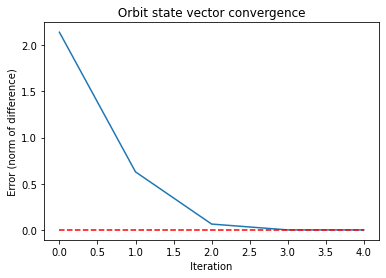

In [10]:
fig, ax = plt.subplots()
ax.plot( np.arange(0,iter+1), error_values )
ax.plot( np.array([0, iter]), error_threshold*np.array([1,1]), "r--" )

plt.xlabel(" Iteration ")
plt.ylabel(" Error (norm of difference) ")
plt.title(" Orbit state vector convergence ");
plt.show()